In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm

In [2]:
# Arima
import itertools
import statsmodels.api as sm
from datetime import datetime, timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf

In [3]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.filterwarnings("ignore")

In [4]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
%matplotlib inline
pd.plotting.register_matplotlib_converters()
plt.rcParams['figure.figsize']=(14,8)
import seaborn
seaborn.set
seaborn.set_style("whitegrid")

In [5]:
def gerar_janelas(lista, tam):
    '''(np.array, int) -> np.array, np.array'''
    x, y = [], []
    n = len(lista)
    for i in range(n-tam):
        janela = lista[i:i+tam]
        x.append(janela)
        y.append(lista[i+tam])
    return np.array(x), np.array(y)

## Treinando dados de cotações

In [6]:
# importando o csv das cotações de venda de moeda estrangeira
moeda = "Dolar"
dados_csv = pd.read_csv("datasets/cotacao_%s.csv"%(moeda.split()[0].lower()))
#dados_csv.tail()

In [7]:
# filtra cotacoes de Fechamento
dados_brutos = dados_csv.loc[dados_csv.tipoBoletim == "Fechamento"]
dados_brutos = dados_brutos.reset_index().drop(["tipoBoletim", "index"], axis=1)
#dados_brutos.tail()

In [53]:
# Renomear as colunas
dados = dados_brutos.copy()
dados.columns = ["cotacao", "dia"]

# usando apenas o dia e ignorando o horário
dados.dia = pd.to_datetime(dados.dia.str[:10])
dados = dados.set_index("dia")

# convertendo formato da parte decimal
dados.cotacao = pd.to_numeric(dados.cotacao.str.replace(",", "."))

# filtrando períodos
dados = dados["2014-03-01":"2018-03-01"]
#dados.head()

In [54]:
fig = px.line(dados, y="cotacao")
fig.update_layout(xaxis_title="Período", yaxis_title="Cotação de Venda (R$)", 
                  title="Cotações de Venda do Dólar")
fig.show()

## Treinamento
Treinar respeitando a ordenação temporal

In [57]:
# número de dias que serão usados para a comparação
N = 7

# tamanho das janelas de dados
tam_janela = 30

# D0 dos dos testes
dia_corte = "2017-02-28"

n_total = dados.shape[0]-tam_janela
n_train = dados[:dia_corte].shape[0]-tam_janela

# conferindo
print("%d %d %d %.1f%%" %(n_total, n_train, n_total-n_train, n_train/n_total*100))

972 722 250 74.3%


In [58]:
# Dias usados no teste de comparações
dias_teste = dados[dia_corte:].head(N+1).index[1:]
dias_teste

DatetimeIndex(['2017-03-02', '2017-03-03', '2017-03-06', '2017-03-07',
               '2017-03-08', '2017-03-09', '2017-03-10'],
              dtype='datetime64[ns]', name='dia', freq=None)

In [59]:
# Dias usados no treino do Keras (para usar nos gráficos)
dias_treino = dados[:dia_corte].index[tam_janela:]
dias_treino

DatetimeIndex(['2014-04-16', '2014-04-17', '2014-04-22', '2014-04-23',
               '2014-04-24', '2014-04-25', '2014-04-28', '2014-04-29',
               '2014-04-30', '2014-05-02',
               ...
               '2017-02-13', '2017-02-14', '2017-02-15', '2017-02-16',
               '2017-02-17', '2017-02-20', '2017-02-21', '2017-02-22',
               '2017-02-23', '2017-02-24'],
              dtype='datetime64[ns]', name='dia', length=722, freq=None)

In [60]:
# gerando as janelas
janelas_x, janelas_y = gerar_janelas(dados.cotacao, tam_janela)

# janelas de treino para o Keras
x_train = janelas_x[:n_train].reshape((n_train, tam_janela, 1))
y_train = janelas_y[:n_train]

# janelas de teste (N dias)
x_arima = janelas_x[n_train:n_train+N]
x_test = x_arima.reshape((N, tam_janela, 1))
y_test = janelas_y[n_train:n_train+N]

In [61]:
datas_x, datas_y = gerar_janelas(dados.index.date, tam_janela)
print(["%s"%x for x in datas_x[n_train]])
print(datas_y[n_train])

['2017-01-16', '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20', '2017-01-23', '2017-01-24', '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-02', '2017-02-03', '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09', '2017-02-10', '2017-02-13', '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17', '2017-02-20', '2017-02-21', '2017-02-22', '2017-02-23', '2017-02-24']
2017-03-01


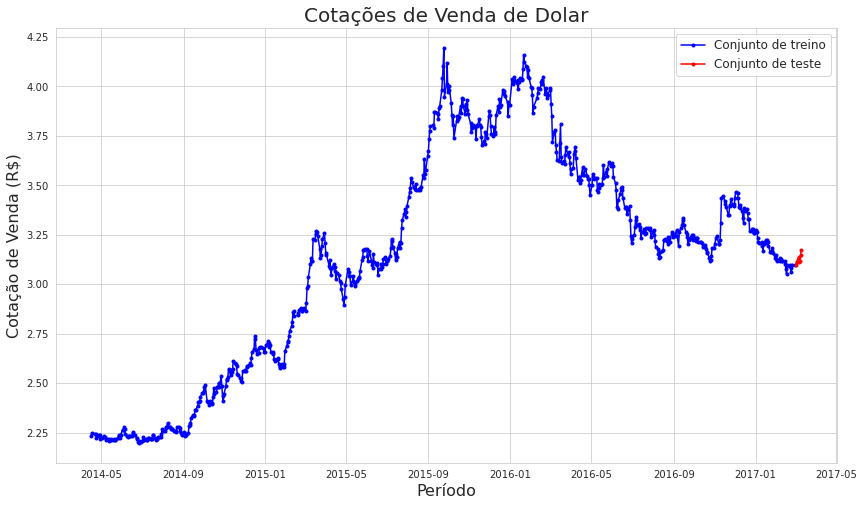

In [62]:
# Gráfico mostrando conjunto de treino e de teste para as redes neurais
plt.plot(dados[:datetime.strptime(dia_corte, "%Y-%m-%d")+timedelta(days=1)].index[tam_janela:], 
         janelas_y[:n_train+1], "b.-", label="Conjunto de treino")
plt.plot(dias_teste, y_test, "r.-", label="Conjunto de teste")
plt.title("Cotações de Venda de %s"%(moeda), fontsize=20)
plt.xlabel("Período", fontsize=16)
plt.ylabel("Cotação de Venda (R$)", fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [98]:
# salvar modelo
#model.save("keras_dolar.h5")

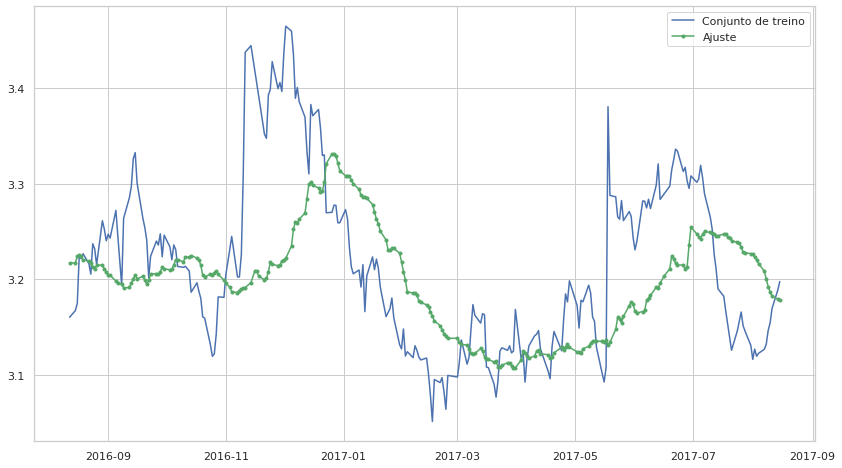

In [359]:
# carregar modelo
model = keras.models.load_model("keras_dolar.h5")

# Plotando previsões versus real do conjunto de treino
y_train_pred = model.predict(x_train).reshape(-1)

plt.plot(dias_treino, y_train, "b-", label="Conjunto de treino")
plt.plot(dias_treino, y_train_pred, "g.-", label="Ajuste")
plt.legend(loc=1)
plt.show()

In [302]:
# erro RMSE = raiz do erro quadrático médio
print("RMSE:", np.sqrt(np.mean((y_train_pred - y_train)**2)))

# erro MAE = erro absoluto médio
print("MAE:", np.mean(np.abs(y_train_pred - y_train)))

RMSE: 0.08330711618473201
MAE: 0.06548415489347555


In [305]:
# Plotando previsões versus real do conjunto de teste
y_keras = model.predict(x_test).reshape(-1)

# conferindo janelas (ok)
#print(y_train[-N:], y_test, y_test_pred)
#print(janelas_y[n_train-2:n_train+2])

## Bloco do Arima

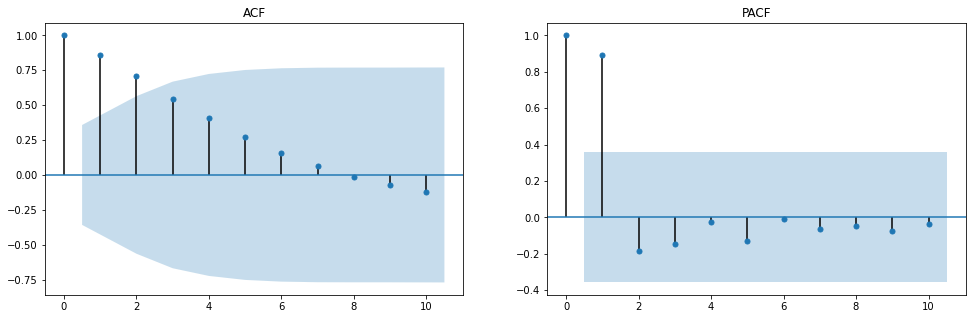

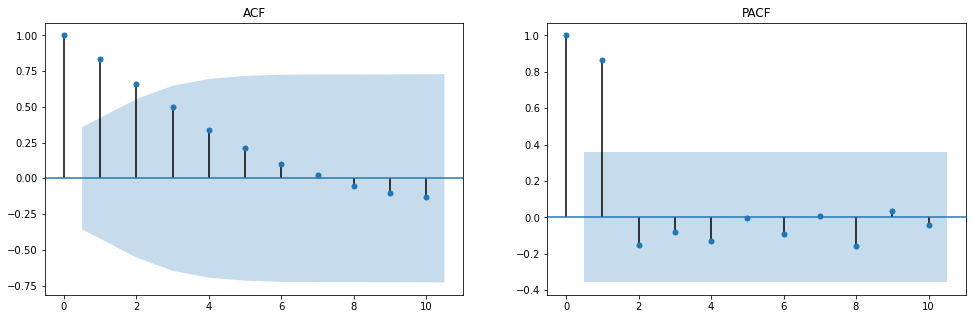

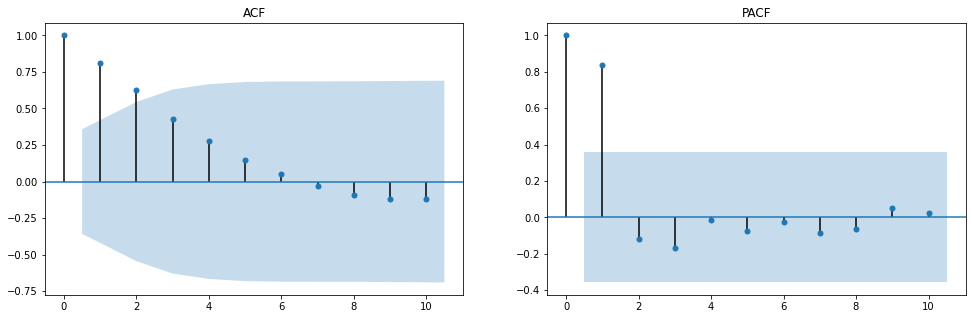

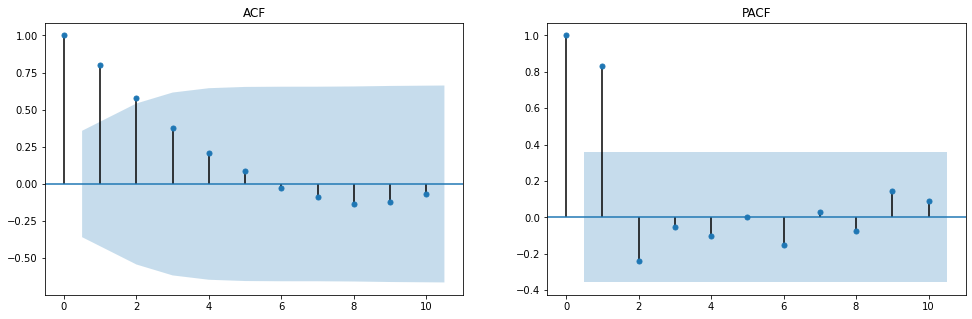

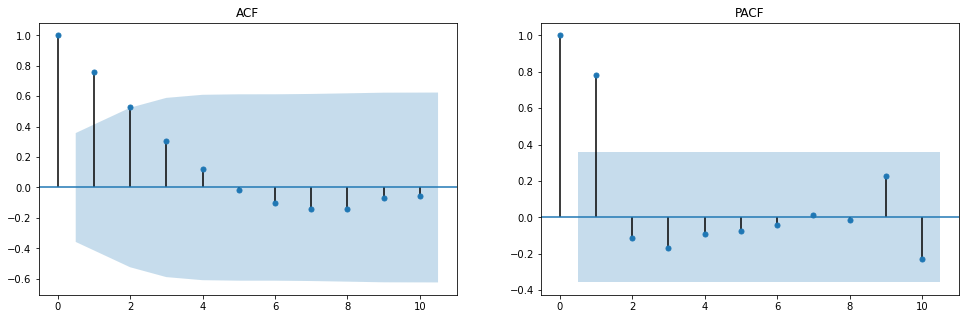

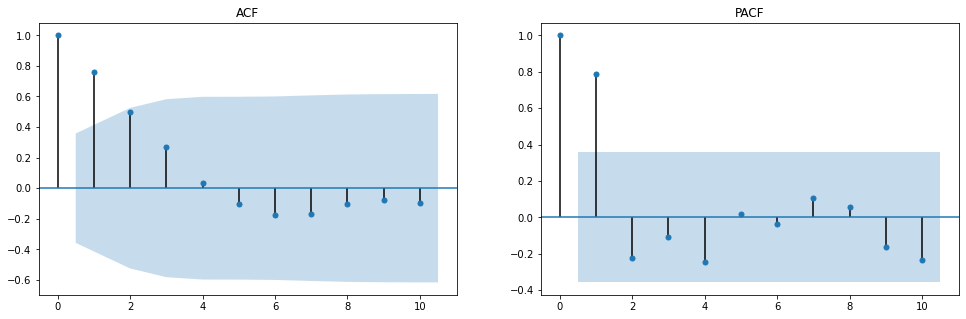

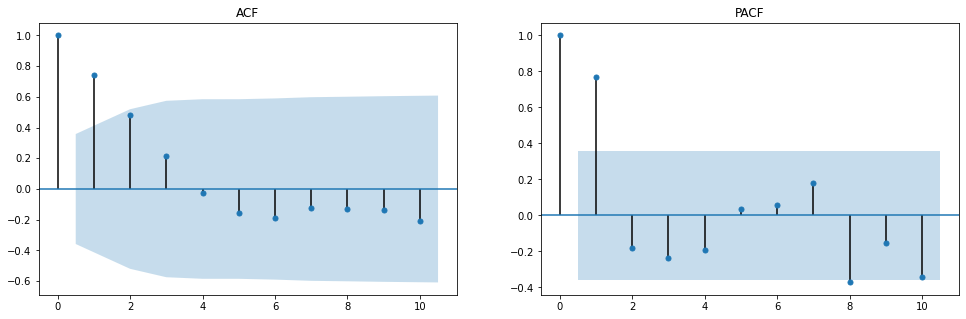

In [18]:
# Autocorrelação
def plotar_autocorrelacao(campo, lags=10):
    '''(np.array, int) -> None'''
    fig, ax = plt.subplots(1, 2, figsize=(16.5, 5))
    acf = plot_acf(campo, lags=lags, ax=ax[0], title="ACF")
    pacf = plot_pacf(campo, lags=lags, ax=ax[1], title="PACF")
    plt.show()

for i in range(N):
    plotar_autocorrelacao(x_arima[i])

### Parâmetros do modelo

    *p é a ordem do componente autoregressiva
    *d é o número de diferenças tomadas na série
    *q é a ordem da componente de médias móveis

In [112]:
p = q = range(0, 3)
d = [0, 1]
T = [5, 7]
pdq = list(itertools.product(p, d, q))[1:] # ignorando (0, 0, 0)
PDQ = list(itertools.product(p, d, q, T))[1:] # ignorando (0, 0, 0)
print(pdq)

[(0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2)]


In [124]:
# Exibe qual o melhor modelo encontrado
for k in range(N):
    print("ARIMA %s" %(list(best_params[k])))

ARIMA [2, 0, 1]
ARIMA [1, 1, 0]
ARIMA [2, 0, 0]
ARIMA [2, 0, 0]
ARIMA [2, 0, 0]
ARIMA [2, 0, 0]
ARIMA [2, 0, 0]


In [169]:
# Previsões das múltiplas janelas
y_arima = []
for k in range(N):
    modelo = ARIMA(x_arima[k], order=(2, 0, 0)).fit()
    y_arima.append(modelo.forecast()[0][0])
    #print(modelo.forecast())

### Bloco Perceptron

In [207]:
from perceptron import Perceptron

In [341]:
y_percep_train = y_train.copy().reshape(-1, 1)
x_percep_train = x_train.copy().reshape(len(x_train), -1)
x_percep_test = x_test.copy().reshape(len(x_test), -1)

In [352]:
perceptron = Perceptron(taxa=0.001, ativacao="elu", N=[20, 10, 1])
perceptron.treinar(x_percep_train, y_percep_train, M=25)

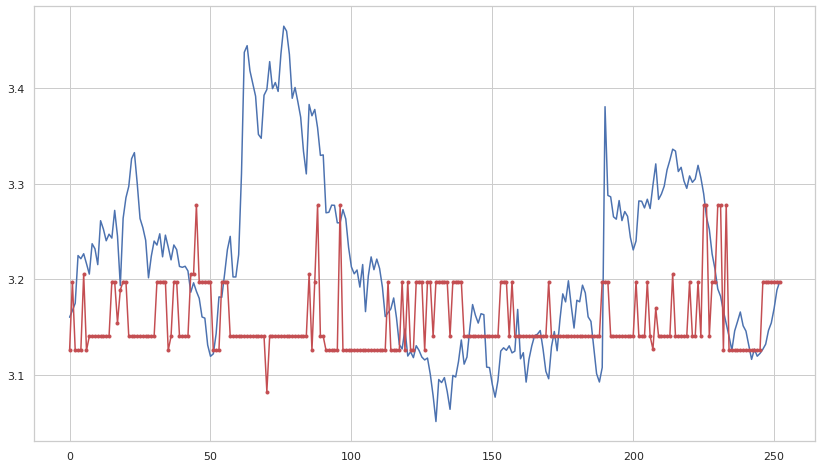

In [354]:
y_percep_train_pred = perceptron.prever(x_percep_train)
plt.plot(y_train, "b-")
plt.plot(y_percep_train_pred, "r.-")
plt.show()

In [355]:
y_percep = perceptron.prever(x_percep_test)
y_percep = y_percep.reshape(-1)

# Plotando tudo junto

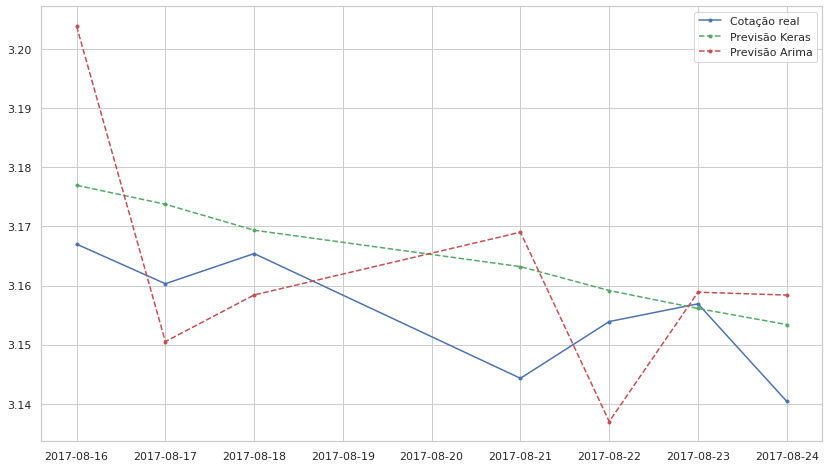

In [378]:
# Plotando tudo junto
plt.plot(dias_teste, y_test, "b.-", label="Cotação real")
plt.plot(dias_teste, y_keras, "g.--", label="Previsão Keras")
plt.plot(dias_teste, y_arima, "r.--", label="Previsão Arima")
#plt.plot(dias_teste, y_percep, "c.--", label="Previsão Perceptron")
plt.legend(loc=0)
plt.show()

In [401]:
for k in range(N):
    print("%s & %.4f & %.4f & %.4f & %.4f \\\\"%(dias_teste[k].date(), 
                                               y_test[k], y_arima[k], y_keras[k], y_percep[k]))

2017-08-16 & 3.1670 & 3.2039 & 3.1770 & 3.1976 \\
2017-08-17 & 3.1603 & 3.1505 & 3.1737 & 3.1402 \\
2017-08-18 & 3.1654 & 3.1584 & 3.1694 & 3.1976 \\
2017-08-21 & 3.1443 & 3.1690 & 3.1632 & 3.1402 \\
2017-08-22 & 3.1539 & 3.1370 & 3.1592 & 3.1402 \\
2017-08-23 & 3.1569 & 3.1589 & 3.1561 & 3.1402 \\
2017-08-24 & 3.1404 & 3.1584 & 3.1534 & 3.1402 \\


In [377]:
# erro RMSE = raiz do erro quadrático médio
print("RMSE Arima: %.4f" %np.sqrt(np.mean((y_arima - y_test)**2)))
print("RMSE Keras: %.4f" %np.sqrt(np.mean((y_test_pred - y_test)**2)))
print("RMSE Perceptron: %.4f\n" %np.sqrt(np.mean((y_percep - y_test)**2)))

# erro MAE = erro absoluto médio
print("MAE Arima: %.4f" %np.mean(np.abs(y_arima - y_test)))
print("MAE Keras: %.4f" %np.mean(np.abs(y_test_pred - y_test)))
print("MAE Perceptron: %.4f\n" %np.mean(np.abs(y_percep - y_test)))

# Correlação de Pearson
print("Correlação: Real x Arima: %.4f" %np.corrcoef(y_test, y_arima)[0, 1])
print("Correlação: Real x Keras: %.4f" %np.corrcoef(y_test, y_keras)[0, 1])
print("Correlação: Real x Perceptron: %.4f" %np.corrcoef(y_test, y_percep)[0, 1])

RMSE Arima: 0.0197
RMSE Keras: 0.0110
RMSE Perceptron: 0.0202

MAE Arima: 0.0165
MAE Keras: 0.0093
MAE Perceptron: 0.0168

Correlação: Real x Arima: 0.3196
Correlação: Real x Keras: 0.7594
Correlação: Real x Perceptron: 0.7271


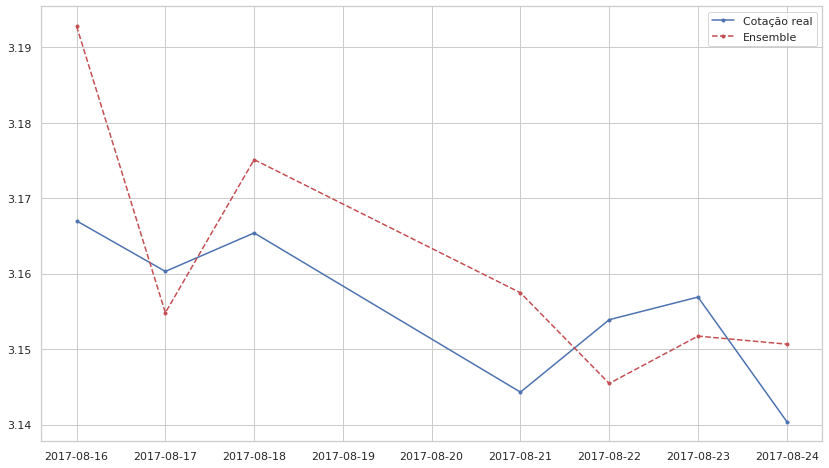

RMSE Média: 0.0129
MAE Média: 0.0112
Correlação: Real x Média: 0.6712


In [376]:
y_media = (y_arima + y_keras + y_percep)/3
plt.plot(dias_teste, y_test, "b.-", label="Cotação real")
plt.plot(dias_teste, y_media, "r.--", label="Ensemble")
plt.legend(loc=0)
plt.show()

print("RMSE Média: %.4f" %np.sqrt(np.mean((y_media - y_test)**2)))
print("MAE Média: %.4f" %np.mean(np.abs(y_media - y_test)))
print("Correlação: Real x Média: %.4f" %np.corrcoef(y_test, y_media)[0, 1])